# Time series forecasting project

In [1]:
# Handle imports up-front
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

## 1. Data loading

### 1.1. Load

In [2]:
raw_data_df=sns.load_dataset('flights')

### 1.2. Inspect 

In [3]:
print(raw_data_df.head())

   year month  passengers
0  1949   Jan         112
1  1949   Feb         118
2  1949   Mar         132
3  1949   Apr         129
4  1949   May         121


In [4]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [5]:
print(raw_data_df.describe())

              year  passengers
count   144.000000  144.000000
mean   1954.500000  280.298611
std       3.464102  119.966317
min    1949.000000  104.000000
25%    1951.750000  180.000000
50%    1954.500000  265.500000
75%    1957.250000  360.500000
max    1960.000000  622.000000


### 1.3. Encode date feature

Pandas has many great tools to work with timeseries data - see the user guide article: '*[Time series / date functionality](https://pandas.pydata.org/docs/user_guide/timeseries.html)*'. First thing to do is convert our string date feature(s) to a Datetime object.

In [6]:
# Make a copy of the raw data to work with
timeseries_df=raw_data_df.copy()

# Extract the string month to a datetime object feature
timeseries_df['month']=pd.to_datetime(raw_data_df.month, format='%b').dt.month

# Use the month and year to create at 'date' datetime feature
timeseries_df['date']=pd.to_datetime(timeseries_df[['year', 'month']].assign(day=1))

# Set the datetime feature as the index
timeseries_df=timeseries_df.set_index('date')

# Keep only the passenger column
timeseries_df.drop(['year', 'month'], axis=1, inplace=True)

# Re-name 'passengers' to 'dependent_var' so we can easily swap datasets without making
# changes to the notebook
timeseries_df.rename(columns={'passengers': 'dependent_var'}, inplace=True)

# Check the result
timeseries_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   dependent_var  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


## 2. EDA

### 2.1. Baseline model performance

Let's set a quick performance baseline using a quick/easy linear regression model.

In [7]:
# Your code here! Hint use a numeric range equal to the length of the dataset for x.

timeseries_df['time_index'] = np.arange(len(timeseries_df))

X = timeseries_df[['time_index']]
y = timeseries_df['dependent_var']

model = LinearRegression()
model.fit(X, y)

timeseries_df['linear_baseline'] = model.predict(X)

In [8]:
timeseries_df['carry_forward_baseline'] = timeseries_df['dependent_var'].shift(1).bfill()

### 2.2. Missing, and/or extreme values

In [9]:
# Plot data as a histogram as you normally would for any numerical data
print(timeseries_df.isnull().sum())

dependent_var             0
time_index                0
linear_baseline           0
carry_forward_baseline    0
dtype: int64


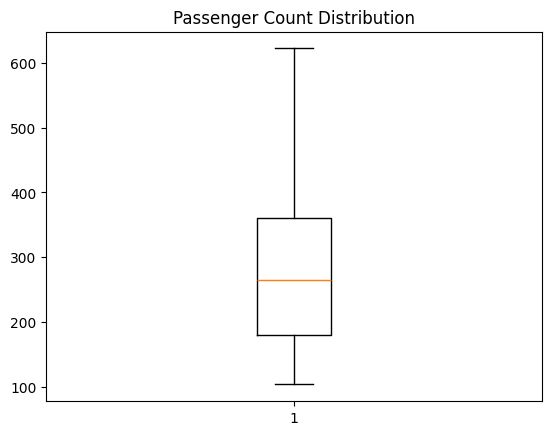

In [10]:
plt.boxplot(timeseries_df['dependent_var'])
plt.title("Passenger Count Distribution")
plt.show()

### 2.3. Timeseries analysis

Let's now take a look at the data as a timeseries. There are a couple of things to look out for here.

1. Is the time axis regular - i.e. are the rows evenly spaced in time.
2. Is the data stationary - i.e. is there a consistent trend over time. The answer to this question will effect how we model the data.
3. Are there regular or cyclical trends - e.g. sales are high on Mondays and low on weekends.

### 2.3.1. Plot the time-series

Let's include predictions from the baseline model too and see what we are working with.

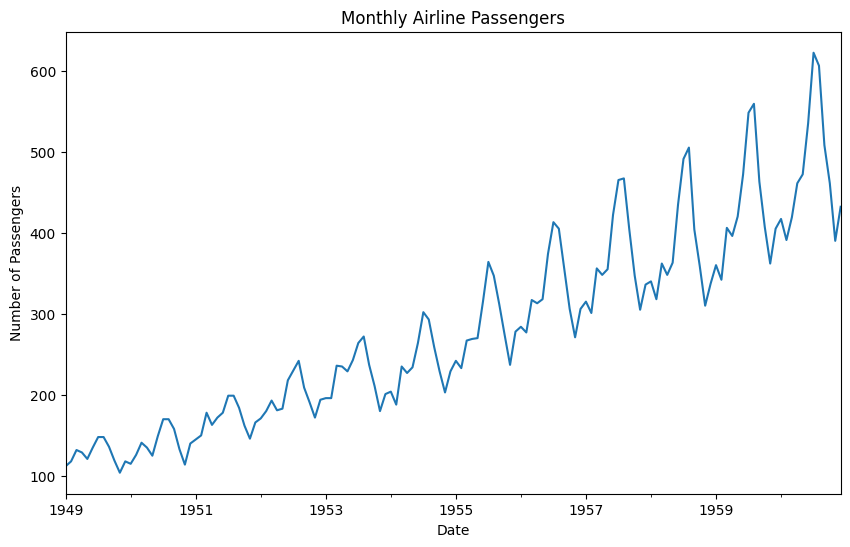

In [11]:
# Plot the data over time and include the linear regression from above
timeseries_df['dependent_var'].plot(title='Monthly Airline Passengers', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

### 2.3.2. Missing timepoints

Next, do a quick check to see if the datetime index we just created is evenly spaced - i.e. the time delta between the rows is always the same.

In [12]:
# Your code here. Hint: take a look and Panda's .resample()
data_range = pd.date_range(start=timeseries_df.index.min(), end=timeseries_df.index.max(), freq='MS')
missing_dates = data_range.difference(timeseries_df.index)
print("Missing dates:", missing_dates)

Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='MS')


### 2.3.3. Stationarity

In [13]:
# Note: you want to be aware of this property of your data, but you may or may not have to do anything with this information right away!
result = adfuller(timeseries_df['dependent_var'])
print("ADF Statistics:", result[0])
print("p-value:", result[1])

ADF Statistics: 0.8153688792060655
p-value: 0.9918802434376413


### 2.3.4. Seasonality

<function matplotlib.pyplot.show(close=None, block=None)>

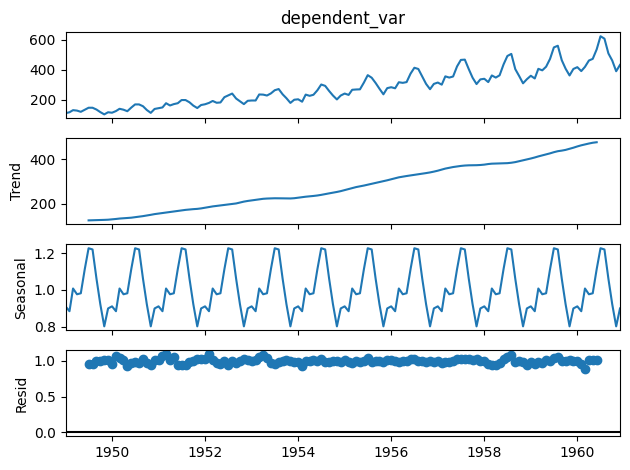

In [14]:
# Note: you want to be aware of this property of your data, but you may or may not have to do anything with this information right away!
decompose_result = seasonal_decompose(timeseries_df['dependent_var'], model='multiplicative', period=12)
decompose_result.plot()
plt.show

## 3. Model training

In [15]:
# Hint use the 'auto_arima()' function from pmdarima as describe in the reading on 4Geeks.
timeseries_df.index = timeseries_df.index.to_period('M')

model = ARIMA(timeseries_df['dependent_var'], order=(5, 1, 0))

arima_result = model.fit()
timeseries_df['arima_forecast'] = arima_result.fittedvalues

## 4. Model evaluation

This result *looks* convincing, at least if you don't look too closely - but how well are we actually doing? We need to implement train-test splitting and/or cross-validation to estimate the actual performance on unseen data!

Breaking up time-series data is a little bit harder than other types of tabular data - we can't just randomly select data points for the training and/or validation sets because the order matters!

Luckily, Scikit-learn can help us out here - take a look at [TimeSeriesSplit](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

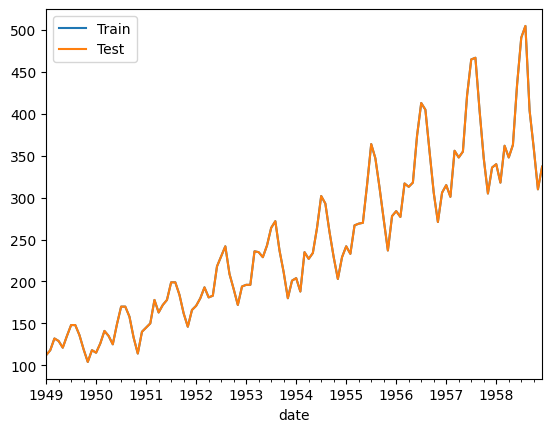

In [16]:
# I'll leave it up to you to try and figure out a good way to evaluate this model!
train = timeseries_df.iloc[:120]
test = timeseries_df.iloc[:120]

train['dependent_var'].plot(label="Train")
test['dependent_var'].plot(label="Test")
plt.legend()

plt.show()

In [17]:
tscv =TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(timeseries_df):
    print("Train:", train_index, "Test:", test_index)

Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] Test: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47] Test: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71] Test: [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95

In [18]:
# Initialize time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Store results
rmse_scores = []

# Iterate through each train-test split
for train_index, test_index in tscv.split(timeseries_df):
    train, test = timeseries_df.iloc[train_index], timeseries_df.iloc[test_index]
    
    # Train the ARIMA model on the training set
    from statsmodels.tsa.arima.model import ARIMA
    model = ARIMA(train['dependent_var'], order=(5, 1, 0))  # Example ARIMA order
    arima_result = model.fit()

    # Generate predictions for the test set
    predictions = arima_result.forecast(steps=len(test))
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test['dependent_var'], predictions))
    rmse_scores.append(rmse)
    
    print(f"Train range: {train.index.min()} to {train.index.max()}, Test range: {test.index.min()} to {test.index.max()}, RMSE: {rmse:.2f}")

Train range: 1949-01 to 1950-12, Test range: 1951-01 to 1952-12, RMSE: 42.48
Train range: 1949-01 to 1952-12, Test range: 1953-01 to 1954-12, RMSE: 41.87
Train range: 1949-01 to 1954-12, Test range: 1955-01 to 1956-12, RMSE: 78.23
Train range: 1949-01 to 1956-12, Test range: 1957-01 to 1958-12, RMSE: 72.34
Train range: 1949-01 to 1958-12, Test range: 1959-01 to 1960-12, RMSE: 101.66


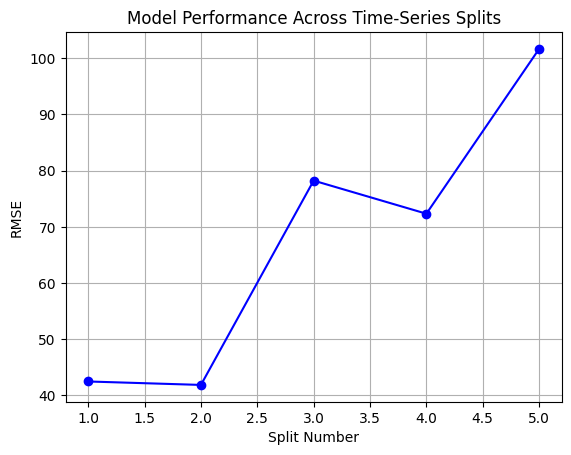

In [19]:
plt.plot(range(1, len(rmse_scores) + 1), rmse_scores, marker='o', linestyle='-', color='b')
plt.title("Model Performance Across Time-Series Splits")
plt.xlabel("Split Number")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

In [26]:
linear_mse = mean_squared_error(timeseries_df['dependent_var'], timeseries_df['linear_baseline'])
linear_rmse = np.sqrt(linear_mse)

carry_forward_mse = mean_squared_error(timeseries_df['dependent_var'], timeseries_df['carry_forward_baseline'])
carry_forward_rmse = np.sqrt(carry_forward_mse)

arima_mse = mean_squared_error(timeseries_df['dependent_var'], timeseries_df['arima_forecast'])
arima_rmse = np.sqrt(arima_mse)

print("Linear Baseline RMSE:", linear_rmse)
print("Carry Forward Baseline RMSE:", carry_forward_rmse)
print("ARIMA RMSE:", arima_rmse)


Linear Baseline RMSE: 45.73619391613882
Carry Forward Baseline RMSE: 33.59315406448165
ARIMA RMSE: 31.222698267967317
